<a href="https://colab.research.google.com/github/mifm/examples/blob/master/test_sens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import importlib
if not importlib.util.find_spec("topfarm"):
  !pip install topfarm

In [7]:
import topfarm
import numpy as np
import xarray as xr
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as ee_2

<xarray.Dataset>
Dimensions:      (diameter: 3, rated_power: 3)
Coordinates:
  * diameter     (diameter) int64 50 65 90
  * rated_power  (rated_power) float64 1e+06 3.35e+06 5e+06
Data variables:
    D            (diameter, rated_power) float64 50.0 50.0 50.0 ... 90.0 90.0
    Rated Power  (diameter, rated_power) float64 1e+06 3.35e+06 ... 5e+06
    AEP          (diameter, rated_power) float64 7.274e+07 ... 3.268e+08
    IRR          (diameter, rated_power) float64 -5.911 21.64 ... 17.04 26.39
    LCOE         (diameter, rated_power) float64 0.0539 0.01888 ... 0.0166

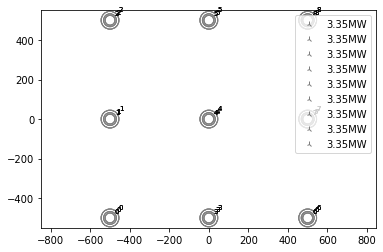

In [8]:
# site set up
n_wt = 9 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model

# vectors for turbine properties: diameter, rated power and hub height
# these are inputs to the cost model
diameters = np.asarray([50, 65, 90])
rated_powers = np.asarray([1.0, 3.35, 5]) * 10**6
nd = diameters.size
nrp = rated_powers.size
xr_data = {k: (["diameter", "rated_power"], np.zeros((nd, nrp))) for k in ['D', 'Rated Power', 'AEP', 'IRR', 'LCOE']}
for i, d in enumerate(diameters):
    for j, rated_power in enumerate(rated_powers):
        windTurbines._diameters[0] = d
        windTurbines.powerCtFunction.power_rated = rated_power
        Drotor_vector = [windTurbines.diameter()] * n_wt 
        power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt 
        hub_height_vector = [windTurbines.hub_height()] * n_wt 
        
        # add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
        distance_from_shore = 30         # [km]
        energy_price = 0.1               # [Euro/kWh] What we get per kWh
        project_duration = 20            # [years]    
        rated_rpm_array = [12] * n_wt    # [rpm]
        water_depth_array = [15] * n_wt  # [m]
        
        # set up function for new cost model with initial inputs as set above
        eco_eval = ee_2(distance_from_shore, energy_price, project_duration)
        
        # calculate aep as a function of x,y positions of the wind turbiens
        aep = wake_model(site.initial_position[:,0], site.initial_position[:,1]).aep().sum(['wd','ws']).values*10**6
        
        # calculate overall internal rate of return (IRR)
        eco_eval.IRR = eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep)
        
        # calculate LCOE
        LCOE = (eco_eval.project_costs_sums['DEVEX']+eco_eval.project_costs_sums['CAPEX']+eco_eval.project_costs_sums['OPEX']+eco_eval.project_costs_sums['ABEX'])/((np.sum(aep))*project_duration)
        
        # plot layout
        windTurbines.plot_xy(site.initial_position[:,0], site.initial_position[:,1])
        
        xr_data['D'][1][i, j] = windTurbines.diameter(0)
        xr_data['Rated Power'][1][i, j] = rated_power
        xr_data['AEP'][1][i, j] = np.sum(aep)
        xr_data['IRR'][1][i, j] = eco_eval.IRR
        xr_data['LCOE'][1][i, j] = LCOE
ds = xr.Dataset(xr_data, coords={"diameter":diameters, "rated_power":rated_powers})
ds